# 数据集和数据加载器
处理数据样本的代码可能会变得混乱且难以维护；理想状态下，我们希望将数据集代码与模型训练代码分离，以提高可读性和模块化。

PyTorch提供了两个数据原语：`torch.utils.data.DataLoader`和`torch.utils.data.Dataset`，允许您使用预加载数据集以及您自己的数据。`Dataset`存储样本及其对应的标签，而`DataLoader`在`Dataset`周围包装一个可迭代对象，以便轻松访问样本。

PyTorch 领域库提供了一些预加载的数据集（例如 FashionMNIST），它们是 torch.utils.data.Dataset 的子类，并实现了特定于特定数据的函数。它们可用于对您的模型进行原型设计和基准测试。您可以在此处找到它们：图像数据集、文本数据集 和 音频数据集

## 加载数据集
以下是如何从 TorchVision 加载 Fashion-MNIST 数据集的示例。Fashion-MNIST 是一个包含 Zalando 文章图像的数据集，包含 60,000 个训练样本和 10,000 个测试样本。每个样本都包含一个 28×28 的灰度图像以及来自 10 个类别之一的关联标签。

我们使用以下参数加载 FashionMNIST 数据集
- root 是存储训练/测试数据的路径，

- train 指定训练或测试数据集，

- download=True 如果 root 中没有数据，则从互联网下载数据。

- transform 和 target_transform 指定特征和标签转换

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(len(training_data))
print(len(test_data))

60000
10000


## 迭代和可视化数据集
我们可以像列表一样手动索引 Datasets：training_data[index]。我们使用 matplotlib 来可视化训练数据中的一些样本。

sample index: 5963
sample index: 7215
sample index: 50321
sample index: 28317
sample index: 10635
sample index: 4786
sample index: 25588
sample index: 24892
sample index: 2060


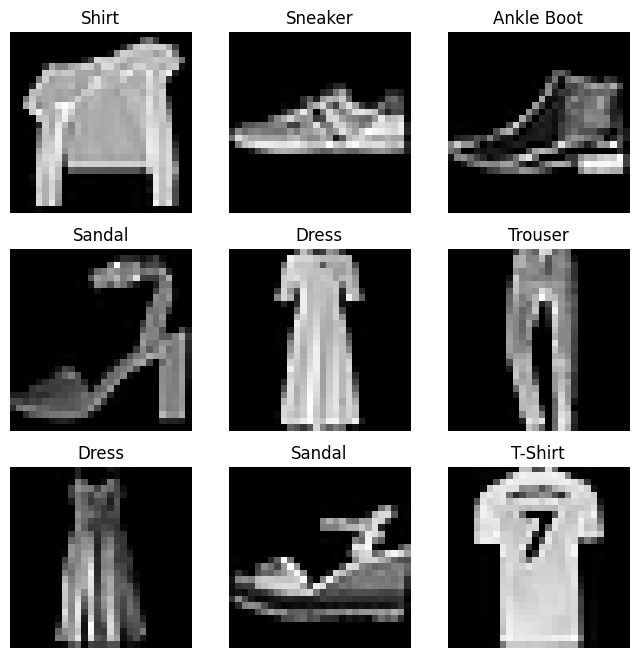

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    print(f"sample index: {sample_idx}")
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show();

# 自定义数据集
自定义 Dataset 类必须实现三个函数：__init__、__len__ 和 __getitem__。看一下这个实现；FashionMNIST 图像存储在目录 img_dir 中，它们的标签分别存储在 CSV 文件 annotations_file 中。

在接下来的章节中，我们将详细介绍每个函数的作用。

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

__init__ 函数在实例化 Dataset 对象时运行一次。我们初始化包含图像的目录、注释文件和两个转换（在下一节中详细介绍）。

labels.csv 文件如下所示
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

__len__ 函数返回数据集中样本的数量。

__getitem__ 函数加载并返回给定索引 idx 处的数据集样本。根据索引，它识别磁盘上图像的位置，使用 read_image 将其转换为张量，从 self.img_labels 中的 csv 数据中检索相应的标签，对它们调用转换函数（如果适用），并以元组的形式返回张量图像和相应的标签。

## 使用DataLoader
Dataset 一次检索一个数据集特征和标签样本。在训练模型时，我们通常希望以“小批量”的形式传递样本，并在每个时期重新排列数据以减少模型过拟合，并使用 Python 的 multiprocessing 来加速数据检索。

DataLoader 是一个可迭代对象，它在一个简单的 API 中为我们抽象了这种复杂性。

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 迭代DataLoader
我们已将该数据集加载到 DataLoader 中，可以根据需要迭代数据集。下面的每次迭代都返回一批 train_features 和 train_labels（分别包含 batch_size=64 个特征和标签）。因为我们指定了 shuffle=True，所以在我们迭代完所有批次后，数据会被打乱（有关数据加载顺序的更精细控制，请查看 Samplers）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


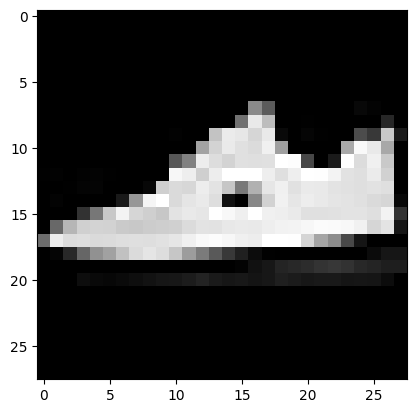

Label: 7


In [12]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")